# Attention Networks

The tutorial will cover the following:

* Preparing a simple dataset for time series forecasting
* How to use a network built via SimpleRNN for time series forecasting
* Adding a custom attention layer to the SimpleRNN network

In [1]:
from pandas import read_csv
import numpy as np
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error

### The Dataset

We will create a fibonacci sequence dataset for our purpose. In Fibonacci sequence, one number is constructed from the previous two numbers. The first 10 numbers of the sequence are shown below:

0, 1, 1, 2, 3, 5, 8, 13, 21, 34, …


When given the previous ‘t’ numbers, can you get a machine to accurately reconstruct the next number? This would mean discarding all the previous inputs except the last two and performing the correct operation on the last two numbers.

For this tutorial, you’ll construct the training examples from t time steps and use the value at t+1 as the target. For example, if t=3, then the training examples and the corresponding target values would look as follows:


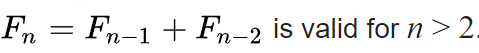
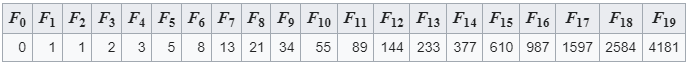

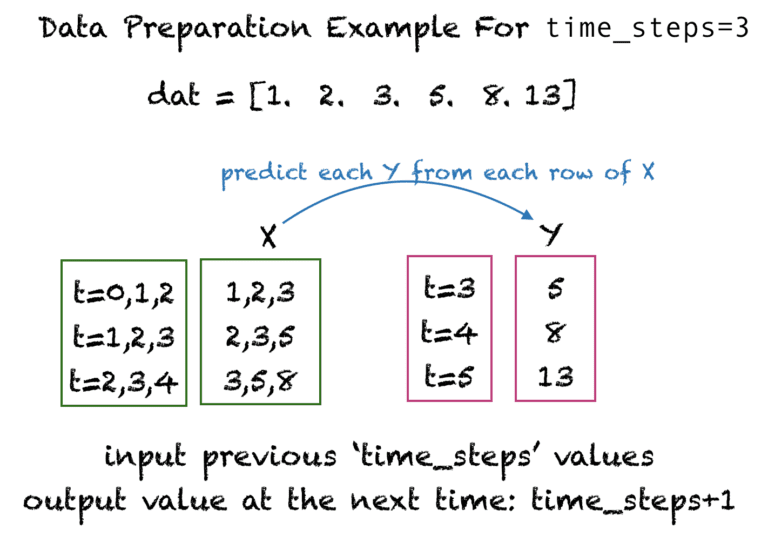

In [2]:
# Prepare data
def get_fib_seq_check_2(n, scale_data=True):
    # Get the Fibonacci sequence
    seq = np.zeros(n)
    fib_n1 = 0.0
    fib_n = 1.0 
    seq[0] = fib_n1
    seq[1] = fib_n
    for i in range(2,n):
            seq[i] = seq[i-1] + seq[i-2]
    seq_copy = seq
    scaler = []
    if scale_data:
        scaler = MinMaxScaler(feature_range=(0, 1))
        seq = np.reshape(seq, (n, 1))
        seq = scaler.fit_transform(seq).flatten()   
    return seq, scaler, seq_copy

In [3]:
# Prepare data
def get_fib_seq_check_1(n, scale_data=True):
    # Get the Fibonacci sequence
    seq = np.zeros(n)
    fib_n1 = 0.0
    fib_n = 1.0
    for i in range(0,n):
            seq[i] = fib_n1 + fib_n
            fib_n1 = fib_n
            fib_n = seq[i]
    scaler = []
    if scale_data:
        scaler = MinMaxScaler(feature_range=(0, 1))
        seq = np.reshape(seq, (n, 1))
        seq = scaler.fit_transform(seq).flatten()   
    return seq, scaler, fib_n

In [4]:
# Prepare data
def get_fib_seq(n, scale_data=True):
    # Get the Fibonacci sequence
    seq = np.zeros(n)
    fib_n1 = 0.0
    fib_n = 1.0
    for i in range(0,n):
            seq[i] = fib_n1 + fib_n
            fib_n1 = fib_n
            fib_n = seq[i]
    scaler = []
    if scale_data:
        scaler = MinMaxScaler(feature_range=(0, 1))
        seq = np.reshape(seq, (n, 1))
        seq = scaler.fit_transform(seq).flatten()   
    return seq, scaler

In [5]:
#
# Check if the function works correctly.
#

dat, scalar, seq_copy = get_fib_seq_check_2(20)

print("Sequence Normalised", dat)
print()
print("Original Series: ",seq_copy)

print()
print()
print()
dat, scalar, fib_N = get_fib_seq_check_1(20)

print("Sequence Normalised", dat)
print()
print("Original Series: ",(dat*(fib_N -1)+1))

print()
print()
print()
dat, scalar = get_fib_seq(20)

print("Sequence Normalised", dat)
print()
print("Original Series: ",seq_copy)

Sequence Normalised [0.00000000e+00 2.39177230e-04 2.39177230e-04 4.78354461e-04
 7.17531691e-04 1.19588615e-03 1.91341784e-03 3.10930399e-03
 5.02272184e-03 8.13202583e-03 1.31547477e-02 2.12867735e-02
 3.44415212e-02 5.57282947e-02 9.01698158e-02 1.45898110e-01
 2.36067926e-01 3.81966037e-01 6.18033963e-01 1.00000000e+00]

Original Series:  [0.000e+00 1.000e+00 1.000e+00 2.000e+00 3.000e+00 5.000e+00 8.000e+00
 1.300e+01 2.100e+01 3.400e+01 5.500e+01 8.900e+01 1.440e+02 2.330e+02
 3.770e+02 6.100e+02 9.870e+02 1.597e+03 2.584e+03 4.181e+03]



Sequence Normalised [0.00000000e+00 9.13659205e-05 1.82731841e-04 3.65463682e-04
 6.39561444e-04 1.09639105e-03 1.82731841e-03 3.01507538e-03
 4.93375971e-03 8.04020101e-03 1.30653266e-02 2.11968936e-02
 3.43535861e-02 5.56418456e-02 9.00867976e-02 1.45820009e-01
 2.35998173e-01 3.81909548e-01 6.17999086e-01 1.00000000e+00]

Original Series:  [1.0000e+00 2.0000e+00 3.0000e+00 5.0000e+00 8.0000e+00 1.3000e+01
 2.1000e+01 3.4000e+01 5.5000e+01 8.

### The following function transforms the fibonacci sequence into training and test dataset.

X and Y looks like the following. From X and Y, we create training and test dataset.

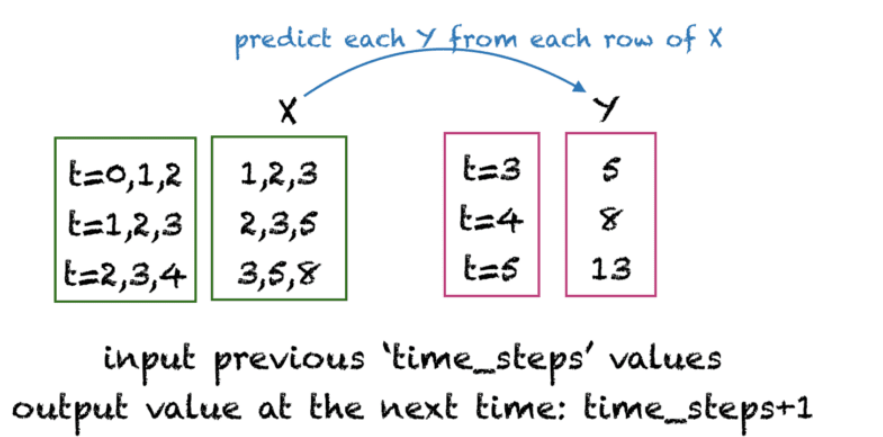

In [6]:
from keras.preprocessing.sequence import TimeseriesGenerator

def get_fib_XY(total_fib_numbers, time_steps, train_percent, scale_data=True):
    dat, scaler = get_fib_seq(total_fib_numbers, scale_data) ## Loading the dataset.
    
    #
    #
    # Your code to create training and test dataset. 
    # Note - function argument total_fib_number is the total number of fibonacci numbers, 
    # time_step is the length of the input, 
    # and train_percent determines the ratio of train and test size 
    #   
    Y_ind = np.arange(time_steps, len(dat), 1)
    Y = dat[Y_ind]
    rows_x = len(Y)
    X = dat[0:rows_x]
    for i in range(time_steps - 1):
        temp = dat[i+1:rows_x+i+1]
        X = np.column_stack((X, temp))
    rand = np.random.RandomState(seed=13)
    idx = rand.permutation(rows_x)
    split = int(train_percent * rows_x)
    train_ind = idx[0:split]
    test_ind = idx[split:]
    trainX = X[train_ind]
    trainY = Y[train_ind]
    testX = X[test_ind]
    testY = Y[test_ind]
    trainX = np.reshape(trainX, (len(trainX),time_steps, 1))
    testX = np.reshape(testX, (len(testX),time_steps, 1))

    return trainX, trainY, testX, testY, scaler

In [7]:
#
# Check if the function works correctly.
#

get_fib_XY(10, 3, 0.8)

(array([[[0.01136364],
         [0.02272727],
         [0.04545455]],
 
        [[0.04545455],
         [0.07954545],
         [0.13636364]],
 
        [[0.07954545],
         [0.13636364],
         [0.22727273]],
 
        [[0.13636364],
         [0.22727273],
         [0.375     ]],
 
        [[0.22727273],
         [0.375     ],
         [0.61363636]]]),
 array([0.07954545, 0.22727273, 0.375     , 0.61363636, 1.        ]),
 array([[[0.        ],
         [0.01136364],
         [0.02272727]],
 
        [[0.02272727],
         [0.04545455],
         [0.07954545]]]),
 array([0.04545455, 0.13636364]),
 MinMaxScaler())

### In the following code, we test the performance with the help of simple RNN.

In [8]:
# Set up parameters
time_steps = 20
hidden_units = 2
epochs = 30  # or epochs = 40 # if you use GPU or Google Colab

#### Create a traditional RNN network

In [9]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mse', optimizer='adam')
    return model

In [10]:
model_RNN = create_RNN(hidden_units=hidden_units, dense_units=1, input_shape=(time_steps,1), 
                   activation=['tanh', 'tanh'])

In [11]:
#
# Your code to print the model summary
#
model_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 2)                 8         
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________


In [12]:
#
# Your code to get the dataset for the network - trainX, trainY, testX, testY, 
# using function get_fib_XY(1200, time_steps, 0.7)
#

trainX, trainY, testX, testY, scalar = get_fib_XY(1200, time_steps, 0.7)

In [13]:
history = model_RNN.fit(trainX, trainY, epochs=epochs, batch_size=1, verbose=1)

Epoch 1/30
826/826 [==============================] - 11s 11ms/step - loss: 4.2755e-04
Epoch 2/30
826/826 [==============================] - 12s 15ms/step - loss: 3.3689e-04
Epoch 3/30
826/826 [==============================] - 13s 16ms/step - loss: 3.0012e-04
Epoch 4/30
826/826 [==============================] - 11s 13ms/step - loss: 2.5892e-04
Epoch 5/30
826/826 [==============================] - 12s 14ms/step - loss: 2.2749e-04
Epoch 6/30
826/826 [==============================] - 12s 15ms/step - loss: 1.9927e-04
Epoch 7/30
826/826 [==============================] - 12s 15ms/step - loss: 1.7770e-04
Epoch 8/30
826/826 [==============================] - 13s 15ms/step - loss: 1.6328e-04
Epoch 9/30
826/826 [==============================] - 13s 15ms/step - loss: 1.4180e-04
Epoch 10/30
826/826 [==============================] - 12s 15ms/step - loss: 1.3529e-04
Epoch 11/30
826/826 [==============================] - 13s 15ms/step - loss: 1.2318e-04
Epoch 12/30
826/826 [====================

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('bmh')

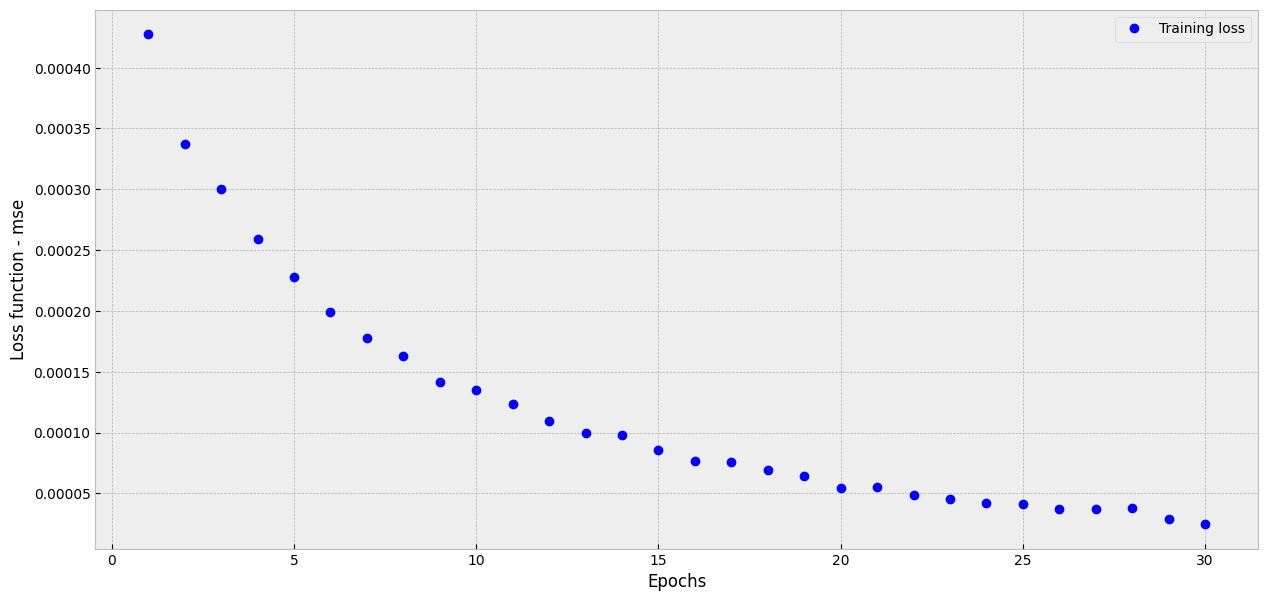

In [18]:
# Training chart

history1_dict = history.history

losses_1 = history1_dict['loss']
Epochs_1 = range(1, len(losses_1) + 1)

plt.figure(num=1, figsize=(15,7))
plt.plot(Epochs_1, losses_1, 'bo', label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function - mse')
plt.legend()
plt.show()

In [19]:
# Evalute model
train_mse = model_RNN.evaluate(trainX, trainY)
test_mse = model_RNN.evaluate(testX, testY)

# Print train and test error metrics
print("Train set MSE = ", train_mse)
print("Test set MSE = ", test_mse)

12/12 [==============================] - 0s 5ms/step - loss: 9.2947e-06
Train set MSE =  2.0618444978026673e-05
Test set MSE =  9.294681149185635e-06


### The following code creates an attention layer. You need to understand each line to know how an attention layer can be created. 

In [21]:
# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context
    


### The following code develops and RNN with attention layer to predict the fibonacci sequence.

In [22]:
def create_RNN_with_attention(hidden_units, dense_units, input_shape, activation):
    x=Input(shape=input_shape)
    RNN_layer = SimpleRNN(hidden_units, return_sequences=True, activation=activation)(x)

    attention_layer = attention()(RNN_layer) ## Note = Attention layer is added here.

    outputs=Dense(dense_units, trainable=True, activation=activation)(attention_layer)
    model=Model(x,outputs)
    model.compile(loss='mse', optimizer='adam')    
    return model    


In [23]:
#
# Your code to create the model with attention. Use activation function 'tanh' and
# function 'create_RNN_with_attention'
#
from keras import activations
attentive_model = create_RNN_with_attention(4, 34,(time_steps,1) , activations.tanh)

In [24]:
#
# Your code to print the model summary
#
attentive_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 4)             24        
                                                                 
 attention (attention)       (None, 4)                 24        
                                                                 
 dense_1 (Dense)             (None, 34)                170       
                                                                 
Total params: 218
Trainable params: 218
Non-trainable params: 0
_________________________________________________________________


In [25]:
#
# Your code to fit the model
# save the results of the training to 'history_2' variable list
# use batch_size=1
#

history_2 = attentive_model.fit(trainX, trainY, epochs=epochs, batch_size=1, verbose=1)

Epoch 1/30
826/826 [==============================] - 13s 15ms/step - loss: 0.0014
Epoch 2/30
826/826 [==============================] - 15s 19ms/step - loss: 0.0014
Epoch 3/30
826/826 [==============================] - 14s 17ms/step - loss: 0.0014
Epoch 4/30
826/826 [==============================] - 16s 19ms/step - loss: 0.0014
Epoch 5/30
826/826 [==============================] - 16s 20ms/step - loss: 0.0013
Epoch 6/30
826/826 [==============================] - 16s 19ms/step - loss: 0.0013
Epoch 7/30
826/826 [==============================] - 14s 17ms/step - loss: 0.0012
Epoch 8/30
826/826 [==============================] - 14s 17ms/step - loss: 0.0011
Epoch 9/30
826/826 [==============================] - 14s 17ms/step - loss: 0.0010
Epoch 10/30
826/826 [==============================] - 13s 16ms/step - loss: 8.7466e-04
Epoch 11/30
826/826 [==============================] - 14s 17ms/step - loss: 7.3316e-04
Epoch 12/30
826/826 [==============================] - 13s 16ms/step - loss: 

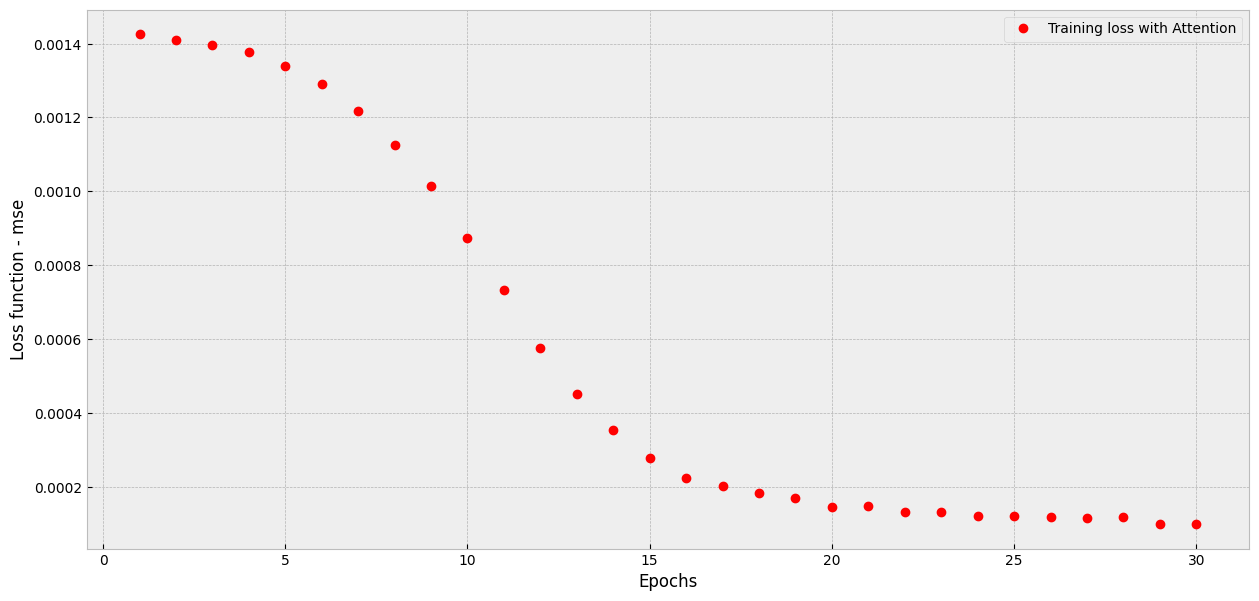

In [26]:
# Training chart

history2_dict = history_2.history

losses_2 = history2_dict['loss']
Epochs_2 = range(1, len(losses_2) + 1)

plt.figure(num=1, figsize=(15,7))
plt.plot(Epochs_2, losses_2, 'ro', label='Training loss with Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss function - mse')
plt.legend()
plt.show()

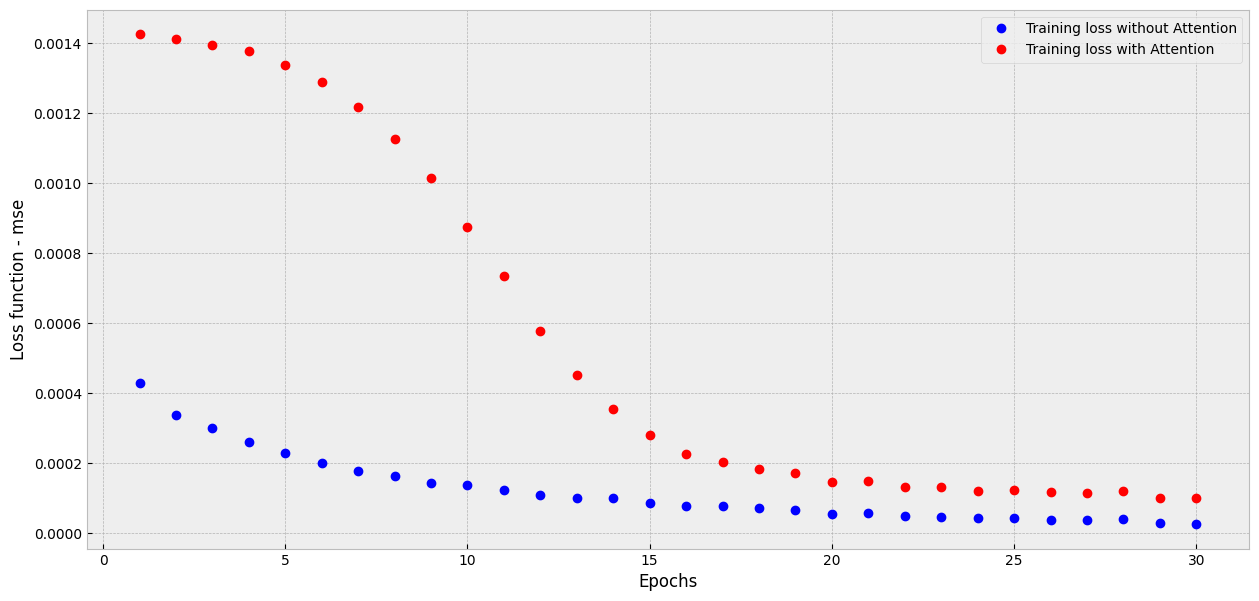

In [27]:
plt.figure(num=1, figsize=(15,7))
plt.plot(Epochs_1, losses_1, 'bo', label='Training loss without Attention')
plt.plot(Epochs_2, losses_2, 'ro', label='Training loss with Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss function - mse')
plt.legend()
plt.show()

In [28]:
#
# your code to Evaluate attention model on training set
# Your code to evaluate the attention model on test set
#
train_mse_with_attention = attentive_model.evaluate(trainX, trainY)
test_mse_with_attention = attentive_model.evaluate(testX, testY)

12/12 [==============================] - 0s 11ms/step - loss: 3.0326e-06


In [29]:
#
# Your code to print train error metric
# Your code to print test error metric
#

print("Train set MSE = ", train_mse_with_attention)
print("Test set MSE = ", test_mse_with_attention)

Train set MSE =  7.488707342417911e-05
Test set MSE =  3.032553422599449e-06


                    Train set MSE  Test set MSE
Simple RNN               0.000021      0.000009
RNN With Attention       0.000075      0.000003


<Axes: >

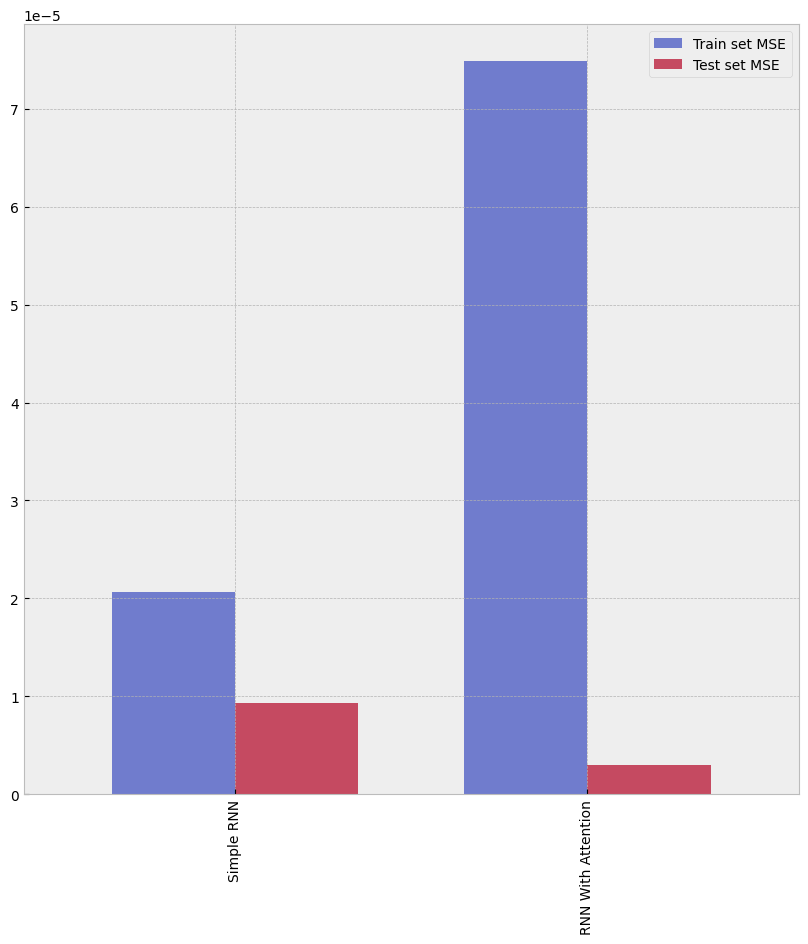

In [31]:
import matplotlib.pyplot as plt
import pandas as pd


ErrorMetrics_pd = pd.DataFrame(
   {
      "Train set MSE": [train_mse, train_mse_with_attention],
      "Test set MSE": [test_mse, test_mse_with_attention]
   },
   index=["Simple RNN", "RNN With Attention"]
) 

print(ErrorMetrics_pd)
fig,ax = plt.subplots(figsize=(10,10))
ErrorMetrics_pd.plot.bar(width = 0.7, alpha = 0.7, cmap = 'coolwarm', ax = ax)

# Lab Logbook requirement: Document the following in Lab Logbook

## Plot the model's performance of the train and test MSE for the 'Simple RNN' and 'RNN with an attention layer'.

### Ensure that no code or other information is added to the logbook and that only required information is present.  Marks will not be awarded if anything else is found in the logbook or instructions are not clearly followed.
### NOTE: DON'T FORGET TO SAVE AND BACK UP YOUR COMPLETED JUPYTER NOTEBOOK AND LAB LOGBOOK ON GITHUB OR ONEDRIVE.

## Challenges (Optional): Test the above model with different parameters, layer size, train and test ratio, and time steps.